# Import Data

In [12]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  5 15:36:05 2018

@author: amariller
"""


%reset -f

import pandas as pd
import math
import numpy as np

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy as cp

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster import hierarchy
from scipy import stats

from IPython.display import display

#import sompy

data_path = "..\\data\\raw\\"

#Product and promo files
df_product = pd.read_csv(data_path + "data_prod_bnd_ita.csv", sep = ";", encoding = 'iso8859_2')
# df_promo = pd.read_csv(data_path + "data_promo_bnd_ita2.csv", sep = ";", encoding = 'iso8859_2')

#History files for P2C1 and P2C4
df_histo_p2c1 = pd.read_csv(data_path + "data_histo_bnd_ita_p2c1.csv", sep = ";", encoding = 'iso8859_2', header = 0)
df_histo_p2c4 = pd.read_csv(data_path + "data_histo_bnd_ita_p2c4.csv", sep = ";", encoding = 'iso8859_2', header = 0)


#Client files
df_client = pd.read_csv(data_path + "data_client_bnd_ita.csv", sep = ";", encoding = 'iso8859_2', header = 0)

In [4]:
products_desc = pd.read_csv(data_path + "bnd_products_desc.csv", sep = ";", encoding = 'iso8859_2', header = 0)

products_desc.head()

,Column1,Key,Description,Product Group key,Product Group key2,Product Group key3,Product Group key4,Product Group key5,Product Group key6,Unit of Measure 2 Ratio,...,SOTTO-TECNO (Description),PRODOTTO (Description),TIPO ARTICOLO (Description),IMBALLO (Description),STD/PROMO (Description),CANALE DISTRIB (Description),CLASSE COGE (Description),FAM MARKETING (Description),BIOLOGICO (Description),GRUPPO MARCA COGE (Description)
0,1,40409,ASPARAGI BONDUE.250DP,GAV001BND250DP,FRABNDASPEAV,FRABNDASPE,FRABND,FRA01,FRA,6,...,LEGUMES,ASPERGES,Obsolčte - fin consommation,CARTON TROTTOIR,STANDARD,ARTICLES GP,PFC+ Frais,A TUTTO VAPORE,NO,BND
1,2,42027,ASPARAGI BONDUE.250DP,GAV001BND250DP,FRABNDASPEAV,FRABNDASPE,FRABND,FRA01,FRA,6,...,LEGUMES,ASPERGES,Obsolčte - fin consommation,CAIS.CPR.400*300*169.PL,STANDARD,ARTICLES GP,PFC+ Frais,A TUTTO VAPORE,NO,BND
2,3,87721,LATTUGHELLA BONDUE.100FS,GLA006BND100FS,FRABNDASTELA,FRABNDASTE,FRABND,FRA01,FRA,8,...,SALADES,MINI LAITUE VERTE,Acheté (matičres 1čres incl.),CARTON TROTTOIR 600*400*140,STANDARD,ARTICLES GP,PFC+ Frais,M'AMA NON M'AMA,NO,BND
3,4,87722,LATTUGHELLA BONDUE.100FS,GLA006BND100FS,FRABNDASTELA,FRABNDASTE,FRABND,FRA01,FRA,8,...,SALADES,MINI LAITUE VERTE,Acheté (matičres 1čres incl.),CAIS.CPR.600*400*169.PL,STANDARD,ARTICLES GP,PFC+ Frais,M'AMA NON M'AMA,NO,BND
4,5,87723,LATTUGHELLA BONDUE.100FS,GLA006BND100FS,FRABNDASTELA,FRABNDASTE,FRABND,FRA01,FRA,8,...,SALADES,MINI LAITUE VERTE,Acheté (matičres 1čres incl.),CAIS.POLY.600*400*165.PL,STANDARD,ARTICLES GP,PFC+ Frais,M'AMA NON M'AMA,NO,BND


# Transform Data

In [2]:
def get_list_client_lvl1(str_ClientPromo, df_AllClient):
    
    list_client = []
    
    for index, row in df_client.iterrows():
       
        if (row['Key_lvl1'] == str_ClientPromo 
        or row['Key_lvl2'] == str_ClientPromo 
        or row['Key_lvl3'] == str_ClientPromo 
        or row['Key_lvl4'] == str_ClientPromo 
        or row['Key_lvl5'] == str_ClientPromo 
        or row['Key_lvl6'] == str_ClientPromo ):                     
            list_client.append(row['Key_lvl1'])
            
    return list_client



def get_list_client_lvl4(str_ClientPromo, df_AllClient):
    
    list_client = []
    
    for index, row in df_client.iterrows():
       
        if (row['Key_lvl1'] == str_ClientPromo 
            or row['Key_lvl2'] == str_ClientPromo 
            or row['Key_lvl3'] == str_ClientPromo 
            or row['Key_lvl4'] == str_ClientPromo 
            or row['Key_lvl5'] == str_ClientPromo 
            or row['Key_lvl6'] == str_ClientPromo ):                     
           
            list_client.append(row['Key_lvl4'])
            
    return list(set(list_client))

test_promo_cli = '1'  

#Get clients of level 1 and 4
list_lvl1_cli = get_list_client_lvl1(test_promo_cli, df_client)
list_lvl4_cli = get_list_client_lvl4(test_promo_cli, df_client)


#Get unique products of level 1 clients
df_HistoCli_p2c1 = df_histo_p2c1.loc[df_histo_p2c1['Client'].isin(list_lvl1_cli)]
list_UnqProd = list(set(df_HistoCli_p2c1['Product']))

#Create empty DF for unique products
df_HistPerProduct_p2c1 = pd.DataFrame(columns = df_HistoCli_p2c1.columns, index = list_UnqProd)




#Actually a group by/SUM of unqiue products
for str_prod in list_UnqProd:
    df_temp = df_HistoCli_p2c1[df_HistoCli_p2c1['Product'] == str_prod]
    df_test = df_temp.sum(axis = 0, skipna = True) 
    df_HistPerProduct_p2c1.loc[str_prod] = df_test
    

df_HistPerProduct_p2c1.drop(['Product', 'Client'], axis = 1, inplace = True)     
df_HistPerProduct_p2c1 = df_HistPerProduct_p2c1[df_HistPerProduct_p2c1.sum(axis = 1) != 0]
df_HistPerProduct_p2c1 = df_HistPerProduct_p2c1[~np.isnan(df_HistPerProduct_p2c1.sum(axis = 1))]



df_HistoCli_p2c4 = df_histo_p2c4.loc[df_histo_p2c4['Client'].isin(list_lvl4_cli)] 
list_UnqProd = list(set(df_HistoCli_p2c4['Product']))
df_HistPerProduct_p2c4 = pd.DataFrame(columns = df_HistoCli_p2c4.columns, index = list_UnqProd)


for str_prod in list_UnqProd:
    df_temp = df_HistoCli_p2c4[df_HistoCli_p2c4['Product'] == str_prod]
    df_test = df_temp.sum(axis = 0, skipna = True) 
    df_HistPerProduct_p2c4.loc[str_prod] = df_test
    
    
df_HistPerProduct_p2c4.drop(['Product', 'Client'], axis = 1, inplace = True) 
df_HistPerProduct_p2c4 = df_HistPerProduct_p2c4[df_HistPerProduct_p2c4.sum(axis = 1) != 0]
df_HistPerProduct_p2c4 = df_HistPerProduct_p2c4[~np.isnan(df_HistPerProduct_p2c4.sum(axis = 1))]


# Display Data

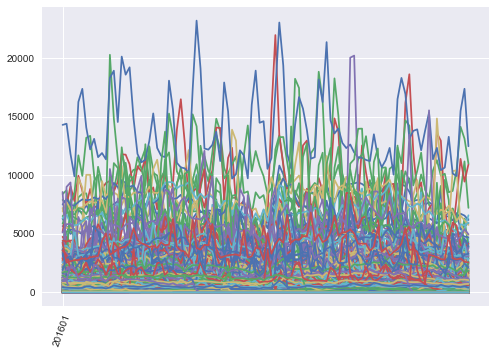

In [5]:
list_it = list(range(len(df_HistPerProduct_p2c1.columns)))[:1]

tick_frequency = 4

for index, row in df_HistPerProduct_p2c1.iterrows():
    plt.plot(list(row))

plt.xticks(list_it[::tick_frequency], list(df_HistPerProduct_p2c1.columns)[::tick_frequency], rotation = 70)
plt.show()

# Save Data

In [6]:
interim_path = "..\\data\\interim\\"

file_name = "HistPerProduct_p2c1.csv"
#df_HistPerProduct_p2c1.to_csv(interim_path+file_name, sep=';', encoding='utf-8')

# Load Saved Data

In [11]:
file_name = "HistPerProduct_p2c1.csv"
df_HistPerProduct_p2c1 = pd.read_csv(interim_path + file_name , sep = ";", encoding = 'utf-8', header = 0)

display(df_HistPerProduct_p2c1)

,Unnamed: 0,201601,201602,201603,201604,201605,201606,201607,201608,201609,...,201743,201744,201745,201746,201747,201748,201749,201750,201751,201752
0,GLA001VLR125FS,2173.0,2571.0,2697.0,2714.0,2795.0,2915.0,2931.0,3069.0,2965.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GWC012NEU500FS,125.0,111.0,97.0,76.0,81.0,80.0,46.0,48.0,54.0,...,440.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GLV001NTA100FS,3254.0,2450.0,2264.0,3334.0,3149.0,3174.0,3200.0,3375.0,3782.0,...,4179.0,4035.0,3031.0,3506.0,3696.0,3800.0,2962.0,3048.0,2896.0,3204.0
3,GLV001BND060SS,1452.0,1592.0,1444.0,1435.0,1424.0,1409.0,1549.0,1507.0,1405.0,...,1324.0,1554.0,1690.0,1340.0,1384.0,1256.0,1201.0,1132.0,1328.0,1333.0
4,GWP007PAM080FP,1228.0,1272.0,1219.0,1256.0,1261.0,1246.0,1329.0,1310.0,1301.0,...,1231.0,1163.0,1220.0,1186.0,1191.0,1149.0,1064.0,1204.0,1173.0,835.0
5,GWT031SPV250BQ,62.0,68.0,69.0,55.0,73.0,61.0,63.0,76.0,77.0,...,107.0,105.0,97.0,111.0,123.0,109.0,91.0,90.0,87.0,80.0
6,GKC002SPV140FP,161.0,159.0,149.0,155.0,156.0,170.0,164.0,162.0,168.0,...,193.0,195.0,185.0,200.0,369.0,329.0,217.0,194.0,216.0,200.0
7,GWC019SPV500FS,57.0,76.0,262.0,192.0,96.0,100.0,96.0,90.0,100.0,...,124.0,128.0,110.0,126.0,116.0,136.0,287.0,226.0,173.0,143.0
8,GCO002NTA200FS,2242.0,2205.0,2146.0,2137.0,1787.0,1628.0,1623.0,3840.0,3777.0,...,2629.0,2708.0,2446.0,2355.0,2264.0,2356.0,2201.0,2183.0,3097.0,2919.0
9,GLV001VEF090FP,10.0,11.0,8.0,11.0,16.0,12.0,11.0,13.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
from pyts.visualization import plot_ts

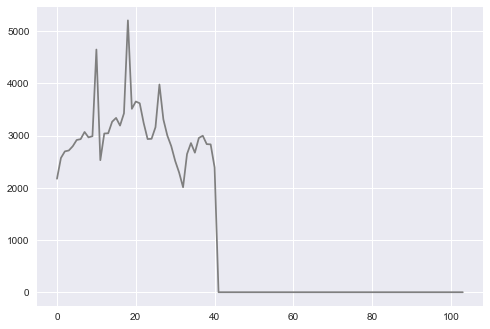

C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


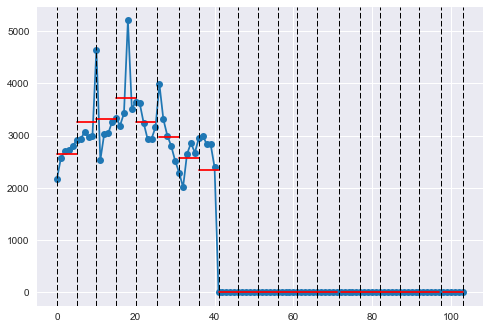

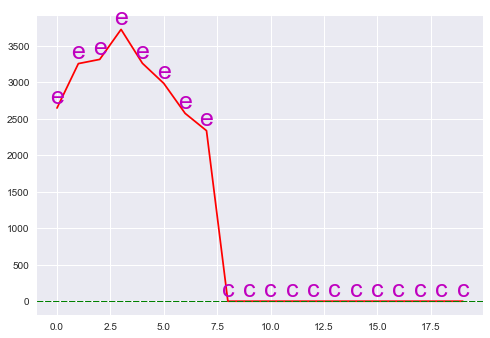

In [84]:
ts=list(df_HistPerProduct_p2c1.iloc[0][1:])
np_ts = np.array(ts)
plot_ts(np_ts)

from pyts.transformation import PAA

paa = PAA(window_size=None, output_size=20, overlapping=True)
X_paa = paa.transform(np_ts)

from pyts.visualization import plot_paa

plot_paa(np_ts, window_size=None, output_size=20, overlapping=True, marker='o')

from pyts.visualization import plot_sax

plot_sax(X_paa[0], n_bins=5, quantiles='gaussian')